In [266]:
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import AtlasScenarios
%matplotlib inline

pp      =  pprint.PrettyPrinter(compact=True)

LOGFILE = 'AtlasLog_200428232056.json'

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

In [267]:
#=== gather data

log = []
with open(LOGFILE,'r') as f:
    for line in f:
        log += [json.loads(line)]

print(len(log))

11438


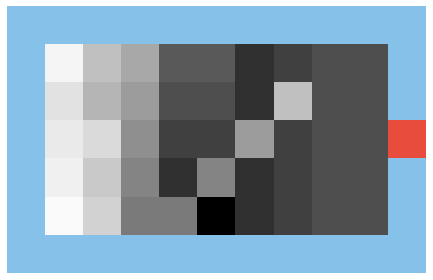

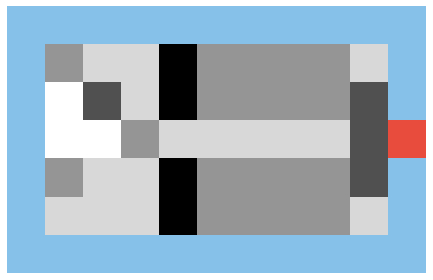

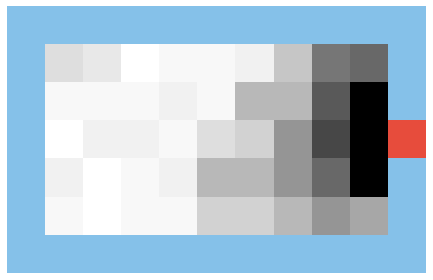

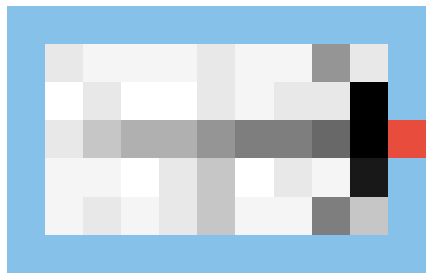

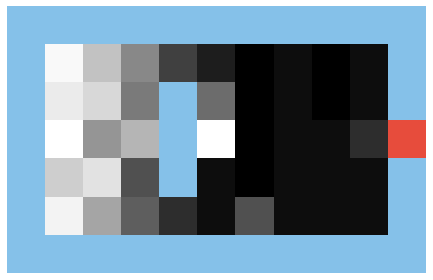

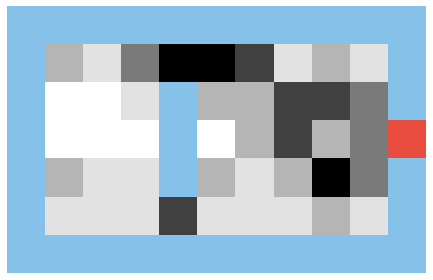

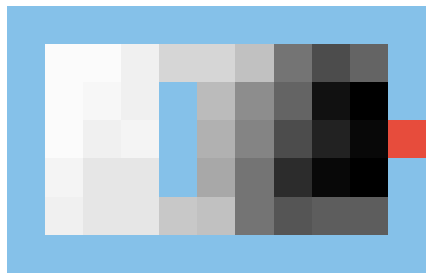

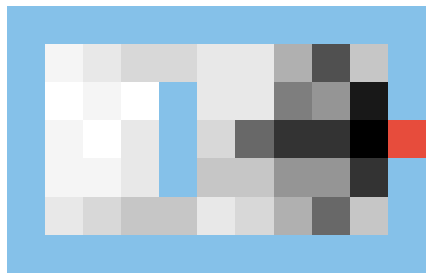

In [268]:
'''
###############################################################################
Heatmap
###############################################################################
'''

#=== create plot

plotsgenerated = []
for run in log:

    # shorthands
    scenarioName = run['scenarioName']
    navAlg       = run['navAlg']
    
    # don't plot same data twice
    if (
        ((scenarioName,navAlg) in plotsgenerated) or
        ('heatmap' not in run)
    ):
        continue
    
    # color cells visited
    data         = np.array(run['heatmap'])
    flat         = data.flatten()
    flat.sort()
    vmax         = flat[-2]
    cmap         = plt.cm.Greys
    norm         = plt.Normalize(0, vmax)
    rgba         = cmap(norm(data))
    
    # color real map
    realMap  = getattr(AtlasScenarios,scenarioName)
    x = 0
    for line in realMap.splitlines():
        if not line.startswith('#'):
            continue
        for (y,c) in enumerate(line):
            if c=='#':
                rgba[x, y, :3] = (133/255,193/255,233/255)
            elif c=='S':
                rgba[x, y, :3] = (231/255, 76/255, 60/255)
        x += 1
    
    (fig,ax) = plt.subplots()
    im       = ax.imshow(rgba, interpolation='nearest')

    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.axis('off')
    fig.savefig(
        os.path.join(
            'plots',
            'heatmap_{0}_{1}.eps'.format(
                scenarioName[len('SCENARIO_'):],
                navAlg[len('Navigation'):],
            ),
        ),
        bbox_inches='tight',
    )
    plt.show()
    
    # remember what I have plotted
    plotsgenerated += [(scenarioName,navAlg)]

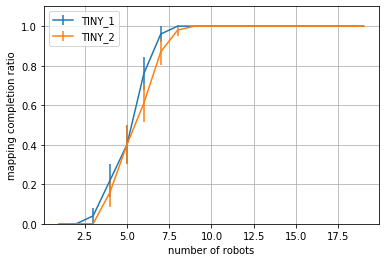

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [269]:
'''
###############################################################################
Completion Ratio
###############################################################################
'''

#=== gather data

data     = {}
for run in log:
    navAlg           = run['navAlg']
    if navAlg!='NavigationRama':
        continue
    scenarioName     = run['scenarioName']
    numRobots        = run['numRobots']
    mappingoutcome   = run['mappingoutcome']
    if scenarioName not in data:
        data[scenarioName]             = {}
    if numRobots not in data[scenarioName]:
        data[scenarioName][numRobots]  = []
    if mappingoutcome=='success':
        data[scenarioName][numRobots] += [1]
    else:
        data[scenarioName][numRobots] += [0]
        
#=== create plot

(fig,ax) = plt.subplots()
lines    = []
for scenario in data.keys():
    x    = []
    y    = []
    yerr = []
    for (k,v) in data[scenario].items():
        x    += [k]
        (m,h) = mean_confidence_interval(v)
        y    += [m]
        yerr += [h]
    lines    += [ax.errorbar(x, y, yerr=yerr,label=scenario[len('SCENARIO_'):])]
ax.grid(True, zorder=5)
plt.xlabel('number of robots')
plt.ylim(0,1.1)
plt.ylabel('mapping completion ratio')
plt.legend(handles=lines)
plt.show()
fig.savefig(os.path.join('plots','completion_ratio.eps'),bbox_inches='tight')

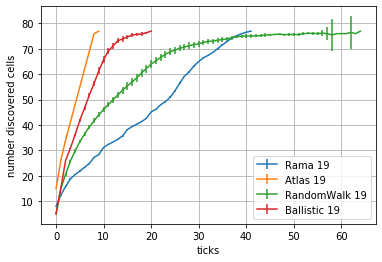

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


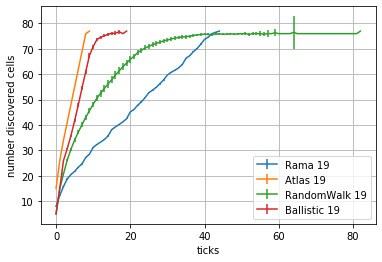

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [270]:
'''
###############################################################################
Mapping Profile
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
allNumRobots        = []
for run in log:
    scenarioName   = run['scenarioName'][len('SCENARIO_'):]
    scenarioNames += [scenarioName]
    numRobots      = run['numRobots']
    allNumRobots  += [numRobots]
    navAlg         = run['navAlg'][len('Navigation'):]
    profile        = run['profile']
    if (scenarioName,numRobots) not in data:
        data[(scenarioName,numRobots)] = {}
    if navAlg not in data[(scenarioName,numRobots)]:
        data[(scenarioName,numRobots)][navAlg] = []
    data[(scenarioName,numRobots)][navAlg] += [profile]
    
for (k1,v1) in data.items():
    for (k2,profiles) in v1.items():
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = []
    for ((scenario,numRobots),v) in data.items():
        if numRobots!=max(allNumRobots):
            continue
        if scenario!=scenarioName:
            continue
        for (alg,profile) in v.items():
            lines    += [ax.errorbar(x=range(len(profile['mean'])),y=profile['mean'],yerr=profile['confidence_interval'],label='{0} {1}'.format(alg,numRobots))]
    ax.grid(True, zorder=5)
    ax.legend()
    plt.xlabel('ticks')
    plt.ylabel('number discovered cells')
    plt.show()
    fig.savefig(os.path.join('plots','mapping_profile_{0}.eps'.format(scenarioName)),bbox_inches='tight')

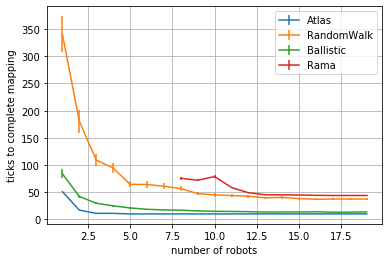

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


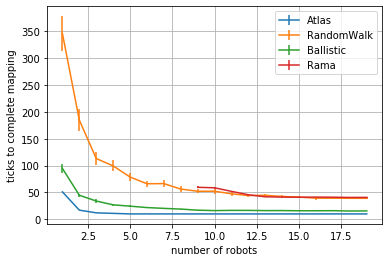

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [271]:
'''
###############################################################################
Mapping Speed
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
incompletecases    = []
for run in log:
    # shorthands
    scenarioName   = run['scenarioName'][len('SCENARIO_'):]
    scenarioNames += [scenarioName]
    navAlg         = run['navAlg'][len('Navigation'):]
    numRobots      = run['numRobots']
    mappingoutcome = run['mappingoutcome']
    numTicks       = run['numTicks']
    if mappingoutcome!='success':
        incompletecases += [(scenarioName,navAlg,numRobots)]
        continue
    if scenarioName not in data:
        data[scenarioName] = {}
    if navAlg not in data[scenarioName]:
        data[scenarioName][navAlg] = {}
    if numRobots not in data[scenarioName][navAlg]:
        data[scenarioName][navAlg][numRobots] = []
    data[scenarioName][navAlg][numRobots] += [numTicks]

# remove cases where not all runs were successful
for (scenarioName,navAlg,numRobots) in set(incompletecases):
    try:
        del data[scenarioName][navAlg][numRobots]
    except KeyError:
        pass

#=== create plot

for scenarioName in data:
    (fig,ax) = plt.subplots()
    lines    = []
    for navAlg in data[scenarioName]:
        x    = []
        y    = []
        yerr = []
        for numRobots in sorted(data[scenarioName][navAlg].keys()):
            l = data[scenarioName][navAlg][numRobots]
            if x and numRobots<x[-1]:
                print(scenarioName,navAlg,numRobots)
            x     += [numRobots]
            (m,h)  = mean_confidence_interval(l)
            y     += [m]
            yerr  += [h]
        lines     += [ax.errorbar(x=x,y=y,yerr=yerr,label='{0}'.format(navAlg))]
    ax.grid(True, zorder=5)
    ax.legend()
    plt.xlabel('number of robots')
    plt.ylabel('ticks to complete mapping')
    plt.show()
    fig.savefig(os.path.join('plots','mapping_speed_{0}.eps'.format(scenarioName)),bbox_inches='tight')